#Importazione Librerie

In [ ]:
#Importazione delle Librerie

from sklearn.model_selection import train_test_split
from matplotlib.pyplot import imread
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io,segmentation,future,color,data,feature,measure,morphology,filters,util,restoration
from scipy import ndimage
import matplotlib.patches as mpatches
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from sklearn.decomposition import DictionaryLearning
import pandas as pd

import json
import plotly.graph_objects as go
import seaborn as sns
import tensorflow as tf
from PIL import Image
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold
from tensorflow import keras
from tensorflow.keras import layers

from skimage.io import imread
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

seed = 42
np.random.seed = seed

#Fase di Caricamento dati

In [ ]:
#Download dataset da Kaggle
!kaggle datasets download -d kmader/synthetic-word-ocr

Dataset URL: https://www.kaggle.com/datasets/kmader/synthetic-word-ocr
License(s): unknown
100% 3.93G/3.93G [03:54<00:00, 18.9MB/s]
100% 3.93G/3.93G [03:54<00:00, 18.0MB/s]


In [ ]:
#Unzip dei file del dataset
!unzip "/content/synthetic-word-ocr.zip" -d "/content/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/train/images/000000275742.jpg  
  inflating: /content/train/images/000000275743.jpg  
  inflating: /content/train/images/000000275744.jpg  
  inflating: /content/train/images/000000275745.jpg  
  inflating: /content/train/images/000000275746.jpg  
  inflating: /content/train/images/000000275747.jpg  
  inflating: /content/train/images/000000275748.jpg  
  inflating: /content/train/images/000000275749.jpg  
  inflating: /content/train/images/000000275750.jpg  
  inflating: /content/train/images/000000275751.jpg  
  inflating: /content/train/images/000000275752.jpg  
  inflating: /content/train/images/000000275753.jpg  
  inflating: /content/train/images/000000275754.jpg  
  inflating: /content/train/images/000000275755.jpg  
  inflating: /content/train/images/000000275756.jpg  
  inflating: /content/train/images/000000275757.jpg  
  inflating: /content/train/images/000000275758.jpg  
  inflating: /content/train/ima

#Pre-processing dei dati

In [ ]:
#Definiamo il percorso delle immagini e della cartella in cui si trovano

map_base_dir = '/content/train/'
map_img_dir = '/content/train/images/'

In [ ]:
#Apriamo e visualizzaziamo il file json che contiene le info sulle segmentazioni (trasformandolo in Dataframe)

json_path = os.path.join("/content/annotation.json")
with open(json_path, 'r') as f:
    annot_data = json.load(f)


img_data=pd.DataFrame(annot_data['images'])
img_data.sample(1)

id         file_name  width  height
147777  10471  000000010471.jpg    300     300

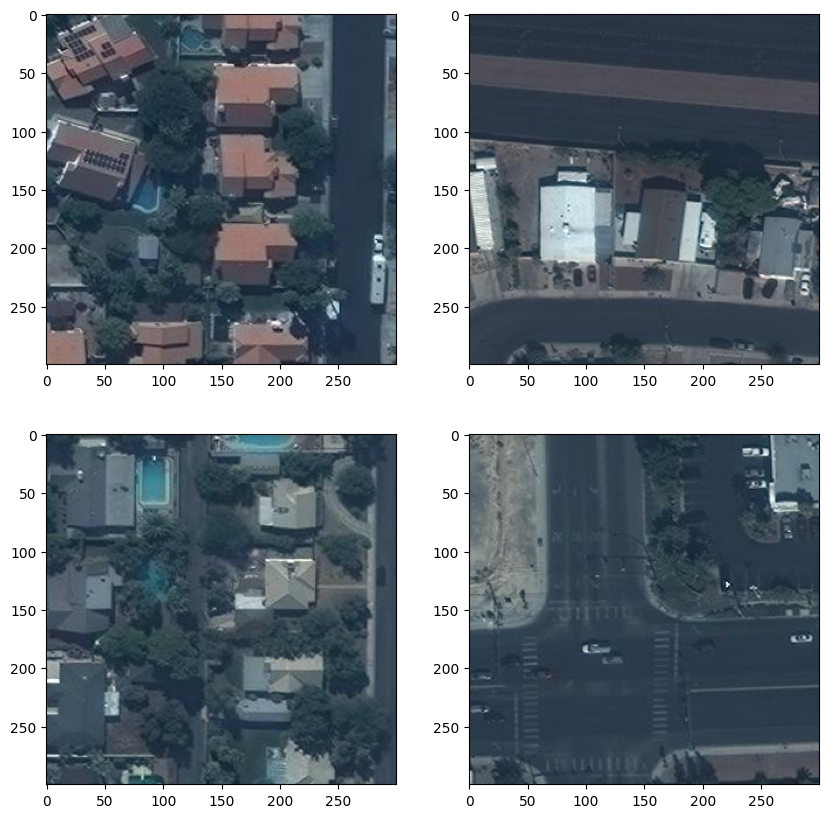

In [ ]:
#Dal dataframe precedentemente creato andiamo a visualizzare le immagini
#nello specifico 4 casuali.

image_df = pd.DataFrame(annot_data['images'])
image_df.sample(3)
fig, m_axs = plt.subplots(2, 2, figsize = (10, 10))
for c_ax, (_, c_row) in zip(m_axs.flatten(), image_df.sample(4).iterrows()):
    img_data = imread(os.path.join(map_img_dir, c_row['file_name']))
    c_ax.imshow(img_data)

In [ ]:
#left join tra dataframe delle immagini e quello delle annotazioni tramite l'id
#delle immagini e visualizziamo lo shape del df finale

annot_df = pd.DataFrame(annot_data['annotations'])

full_df = pd.merge(annot_df, image_df, how='left', left_on = 'image_id', right_on='id').dropna()
print(image_df.shape[0], '+', annot_df.shape[0], '->', full_df.shape[0])

280741 + 2395553 -> 2395553


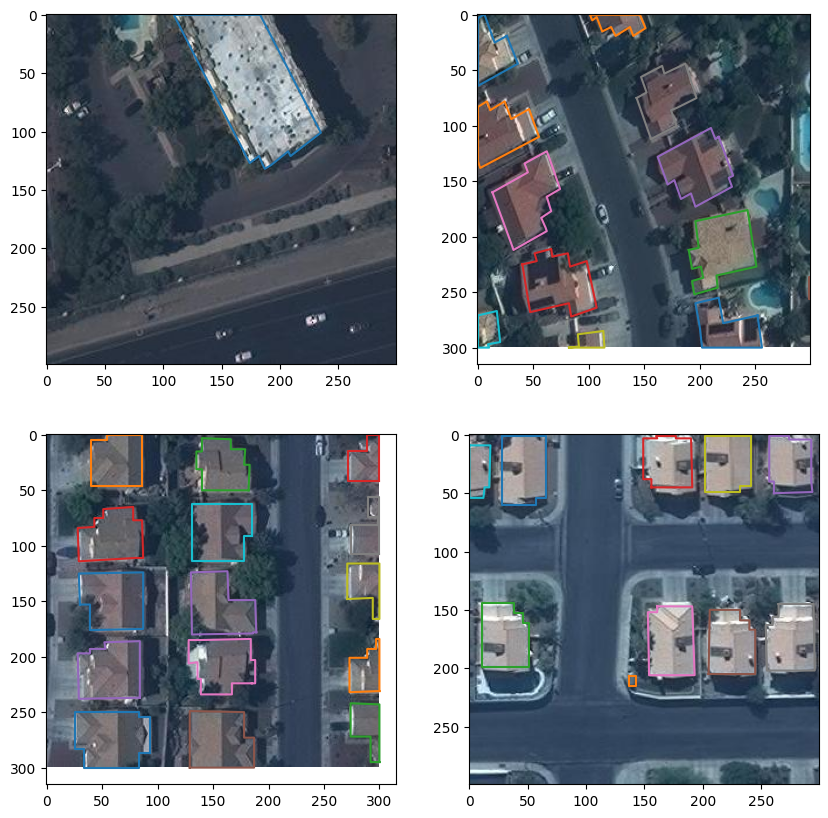

In [ ]:
#Il codice crea una griglia 2x2 di sottotrame in cui vengono visualizzate
#immagini con le loro rispettive segmentazioni sovrapposte.

fig, m_axs = plt.subplots(2, 2, figsize = (10, 10))
for c_ax, (c_id, c_df) in zip(m_axs.flatten(), full_df.groupby('image_id')):
    img_data = imread(os.path.join(map_img_dir, c_df['file_name'].values[0]))
    c_ax.imshow(img_data)
    #qui tracciamo le segmentazioni
    for _, c_row in c_df.iterrows():
        xy_vec = np.array(c_row['segmentation']).reshape((-1, 2)) #rimodella i dati segmentation in un array
        c_ax.plot(xy_vec[:, 0], xy_vec[:, 1], label = c_df['id_x']) #qui tracciamo le linee delle segmentazioni sugli assi

In [ ]:
#questa funzione prende in input un immagine ed un dataframe contenente
#le info sulla segmentazione dell immagine, la funzione poi
#genera una mappa binaria che rappresenta le aree segmentate sull'immagine.

from matplotlib.path import Path
from skimage.color import label2rgb

def rows_to_segmentation(in_img, in_df):
    xx, yy = np.meshgrid(range(in_img.shape[0]),
                range(in_img.shape[1]),
               indexing='ij')
    out_img = np.zeros(in_img.shape[:2])  #inizializziamo l'immagine di output
    for _, c_row in in_df.iterrows():
        xy_vec = np.array(c_row['segmentation']).reshape((-1, 2)) #coverte i dati segmentazioni in un array
        c_ax.plot(xy_vec[:, 0], xy_vec[:, 1], label = c_df['id_x'])
        xy_path = Path(xy_vec)  #crea dei percorsi chiusi(le maschere a partire dalle coordinate)
        #aggiorna l'immagine per evidenziare le aree segmentate
        out_img += xy_path.contains_points(np.stack([yy.ravel(),
                                                     xx.ravel()], -1)).reshape(out_img.shape)
    return out_img

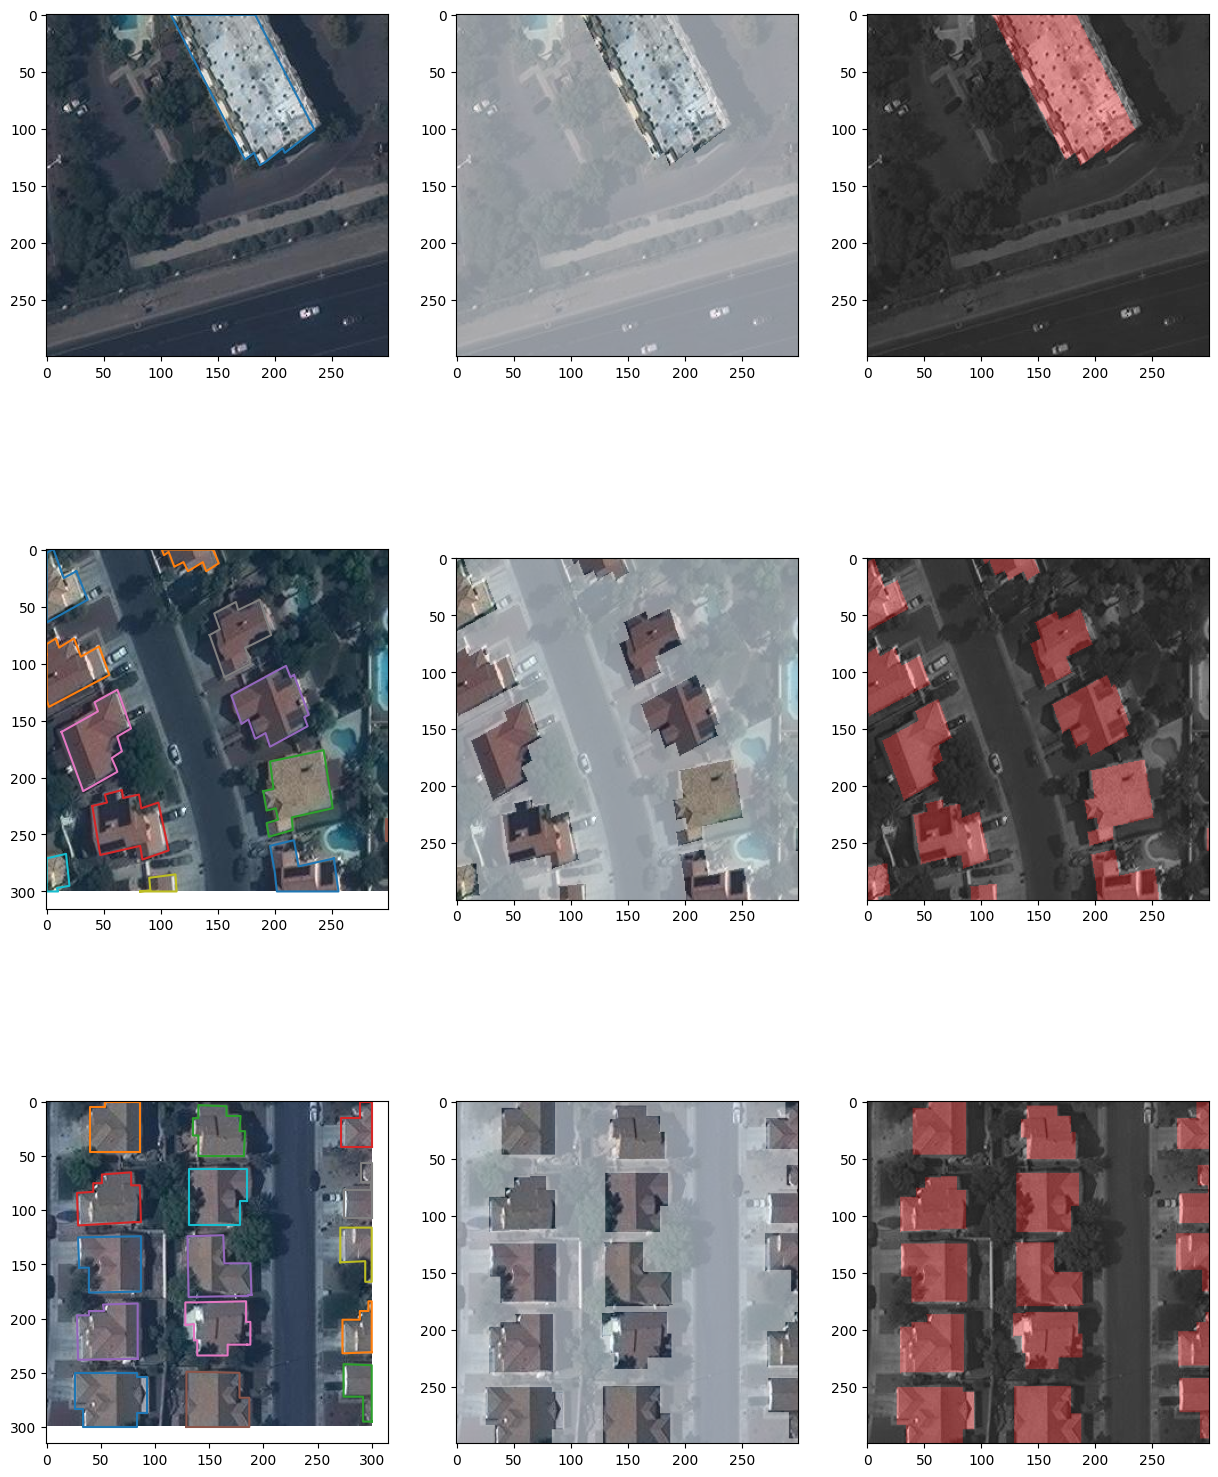

In [ ]:
#qui andiamo a visualizzare 3 sottotrame per singola immagine (c_ax,d_ax,f_ax)
#che sono 3 diversi modi di segmentare l'immagine originale (con colori, con trasparenza e usando il rosso))

fig, m_axs = plt.subplots(3, 3, figsize=(15, 20))
for (c_ax, d_ax, f_ax), (c_id, c_df) in zip(m_axs, full_df.groupby('image_id')):
    img_data = imread(os.path.join(map_img_dir, c_df['file_name'].values[0]))
    c_ax.imshow(img_data)

    out_img = rows_to_segmentation(img_data, c_df)

    rgba_img = np.concatenate([img_data,
                               np.clip(np.expand_dims(127*out_img+127, -1), 0, 255).astype(np.uint8)
                              ], -1)
    d_ax.imshow(rgba_img)

    f_ax.imshow(label2rgb(image=img_data, label=out_img, bg_label=0))

In [ ]:
#Qui dividiamo il dataset in due parti: un set di addestramento (training) che contiene
#il 75% delle immagini e delle loro annotazioni, e un set di validazione (validation) che contiene il 25% rimanente.

from sklearn.model_selection import train_test_split
train_ids, valid_ids = train_test_split(image_df['id'], test_size = 0.25)
train_df = full_df[full_df['image_id'].isin(train_ids)]
valid_df = full_df[full_df['image_id'].isin(valid_ids)]
print(train_df.shape[0], 'training boxes')
print(valid_df.shape[0], 'validation boxes')

1796525 training boxes
599028 validation boxes


#Funzione Batch

In [ ]:
"""Generatore di batch di immagini da cui crea la maschera e sopratutto applica il resize"""


import threading
import os
import numpy as np
import torch
import torchvision.transforms as T
from skimage.io import imread


#Definiamo le trasformazioni di PyTorch
resize_image = T.Resize((256, 256), interpolation=T.InterpolationMode.BILINEAR)
resize_mask = T.Resize((256, 256), interpolation=T.InterpolationMode.BILINEAR)


def batch_img_gen(in_df, batch_size):
    all_groups = list(in_df.groupby('image_id'))
    out_img, out_seg = [], []

    while True:
        #Permuta gli indici dei gruppi per presentare le img in maniera casuale
        permuted_indices = np.random.permutation(len(all_groups))

        for i in permuted_indices:
            (_, c_df) = all_groups[i]

            img_data = imread(os.path.join(map_img_dir, c_df['file_name'].values[0]))

            #Applichiamo il resize all'immagine originale
            img_tensor = torch.tensor(img_data).permute(2, 0, 1).float()       # [C, H, W] convenzione Pytorch
            img_resized = resize_image(img_tensor).numpy().transpose(1, 2, 0)  # [H, W, C]

            #Creiamo la maschera, la convertiamo in tensore e poi applichiamo il resize
            mask_data = np.expand_dims(rows_to_segmentation(img_data, c_df), -1)
            mask_tensor = torch.tensor(mask_data).permute(2, 0, 1).float()      # [C, H, W]
            mask_resized = resize_mask(mask_tensor).numpy().transpose(1, 2, 0)  # [H, W, C]

            out_img.append(img_resized)
            out_seg.append(mask_resized)

            if len(out_img) >= batch_size:
                yield (np.stack(out_img, 0) / 255.0).astype(np.float32), np.stack(out_seg, 0).astype(np.float32)
                out_img, out_seg = [], []


x (8, 256, 256, 3) float32 0.04845559 1.0
y (8, 256, 256, 1) float32 0.0 1.0


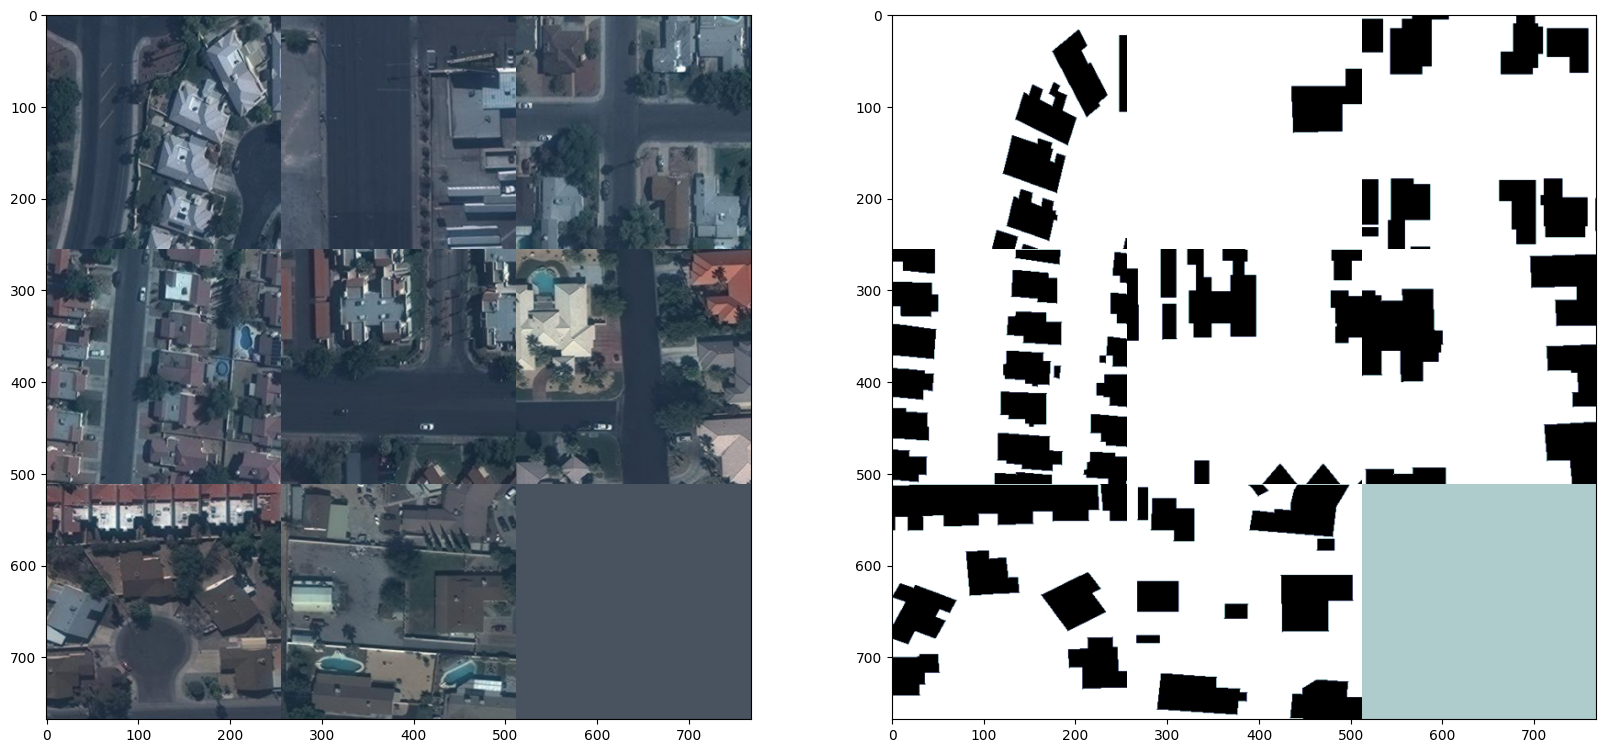

In [ ]:
#Qui estraiamo un batch di immagini e segmentazioni di validazione,
#e poi visualizziamo le immagini e le segmentazioni in due sottotrame separate.
#Visualizza in un'unica soluzione le 8 immagini(batch_size) passate.


from skimage.util import montage

valid_gen = batch_img_gen(valid_df, 8)

t_x, t_y = next(valid_gen)
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
ax1.imshow(montage_rgb(t_x))
ax2.imshow(montage(t_y[:, :, :, 0]), cmap = 'bone_r')

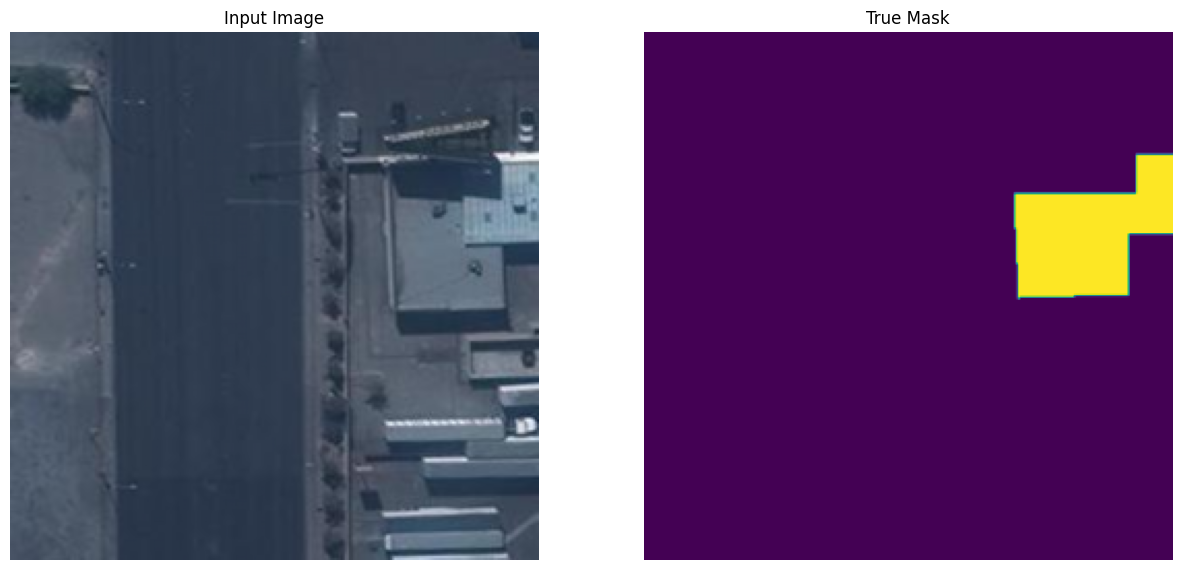

In [ ]:
#la funzione display permette di confrontare le diverse immagini e maschere.

def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ["Input Image", "True Mask"]
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis("off")
    plt.show()

display([t_x[1],t_y[1,:,:,0]])  #ambiando i primi numeri di t_x e t_y possiamo vedere le diverse 'maschere' delle immagini.

#Definizione Modello e Metriche

In [ ]:
BATCH_SIZE = 24

In [ ]:
#Metrciche custom

import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
import tensorflow as tf
from keras import backend as K


def dice_coef(y_true, y_pred, smooth=1):
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    return tf.reduce_mean((2. * intersection + smooth) / (union + smooth), axis=0)  #formula del coeff. di Dice.

def dice_p_bce(in_gt, in_pred):
    return 0.05*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)

def true_positive_rate(y_true, y_pred):
    y_true_flat = tf.keras.layers.Flatten()(y_true)   #trasformiamo in vettori unidimensionali
    y_pred_flat = tf.keras.layers.Flatten()(tf.round(y_pred))
    return tf.reduce_sum(y_true_flat * y_pred_flat) / tf.reduce_sum(y_true_flat)    #TP/TP+FN


optimizer = Adam(learning_rate=0.001)

In [ ]:
import tensorflow as tf

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

#Build the model

inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path

u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32,(2,2), strides=(2,2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1])
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c9)


outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer=optimizer, loss=dice_p_bce , metrics=[dice_coef, 'binary_accuracy', true_positive_rate,])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 256, 256, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 16)   │            448 │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256, 256, 16)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 16)   │          2,320 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 16)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 32)   │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128, 128, 32)   │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 32)   │          9,248 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 32)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64, 64, 64)     │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 64)     │         36,928 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 64)     │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 32, 32, 128)    │              0 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 128)    │        147,584 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 128)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)       

 Total params: 1,941,105 (7.40 MB)

 Trainable params: 1,941,105 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

#Training del modello e definizione Callbacks

In [ ]:
#Model Checkponit/Callbacks

from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.weights.h5".format('model_building_segmentation')

checkpoint = ModelCheckpoint(weight_path, monitor='val_dice_coef', verbose=1,
                             save_best_only=True, mode='max', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5,
                                   patience=3,
                                   verbose=1, mode='max', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_dice_coef",
                      mode="max",
                      patience=5)
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [ ]:
#FIT DEL MODELLO.

valid_gen = batch_img_gen(valid_df, BATCH_SIZE)

loss_history = [model.fit(batch_img_gen(train_df, BATCH_SIZE),
                             steps_per_epoch=min(train_ids.shape[0]//BATCH_SIZE, 100),
                             epochs=50,
                             validation_data = valid_gen,
                             validation_steps = min(train_ids.shape[0]//BATCH_SIZE, 50),
                             callbacks=callbacks_list)]

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 953ms/step - binary_accuracy: 0.5126 - dice_coef: 0.3885 - loss: -0.3414 - true_positive_rate: 0.7703
Epoch 1: val_dice_coef improved from -inf to 0.55501, saving model to model_building_segmentation_weights.best.weights.h5
100/100 ━━━━━━━━━━━━━━━━━━━━ 170s 1s/step - binary_accuracy: 0.5139 - dice_coef: 0.3892 - loss: -0.3421 - true_positive_rate: 0.7700 - val_binary_accuracy: 0.8059 - val_dice_coef: 0.5550 - val_loss: -0.5164 - val_true_positive_rate: 0.6307 - learning_rate: 0.0010
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 978ms/step - binary_accuracy: 0.7826 - dice_coef: 0.5617 - loss: -0.5222 - true_positive_rate: 0.7296
Epoch 2: val_dice_coef improved from 0.55501 to 0.57460, saving model to model_building_segmentation_weights.best.weights.h5
100/100 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - binary_accuracy: 0.7826 - dice_coef: 0.5617 - loss: -0.5223 - true_positive_rate: 0.7297 - val_binary_accuracy: 0.8261 - val_dice_coef: 0.5746 - val_loss: 

In [ ]:
#Salvataggio modello

import tensorflow as tf

model.save('/content/model_building_segmentation.keras')

# Abilitare la deserializzazione non sicura
tf.keras.config.enable_unsafe_deserialization()

# Ora carica il modello
loaded_model = tf.keras.models.load_model('/content/model_building_segmentation.keras',custom_objects={'dice_coef': dice_coef,'true_positive_rate': true_positive_rate, 'dice_p_bce' : dice_p_bce})

In [ ]:
#CELLA PER CARICARE IL MODELLO. RUNNARE SOLO SE CARICHIAMO IL MODELLO DA LOCALE

# Abilitare la deserializzazione non sicura
tf.keras.config.enable_unsafe_deserialization()

# Ora carica il modello
loaded_model = tf.keras.models.load_model('/content/model_building_segmentation (3).keras',custom_objects={'dice_coef': dice_coef,'true_positive_rate': true_positive_rate, 'dice_p_bce' : dice_p_bce})

#History loss Plot

In [ ]:
def plot_history(history):

    train_loss = history.history['loss']

    val_loss = history.history['val_loss']

    train_acc = history.history['binary_accuracy']
    train_acc1 = history.history['dice_coef']
    train_acc2 = history.history['true_positive_rate']

    val_acc = history.history['val_binary_accuracy']
    val_acc1 = history.history['val_dice_coef']
    val_acc2 = history.history['val_true_positive_rate']

    loss_trace = go.Scatter(
        x=list(range(1, len(train_loss) + 1)),
        y=train_loss,
        mode='lines',
        name='Train Loss-dice_p_bce'
    )


    val_loss_trace = go.Scatter(
        x=list(range(1, len(val_loss) + 1)),
        y=val_loss,
        mode='lines',
        name='Validation Loss-dice_p_bce'
    )

    acc_trace = go.Scatter(
        x=list(range(1, len(train_acc) + 1)),
        y=train_acc,
        mode='lines',
        name='Train-Binarary Accuracy'
    )

    acc_trace1 = go.Scatter(
        x=list(range(1, len(train_acc1) + 1)),
        y=train_acc1,
        mode='lines',
        name='Train-dice_coef'
    )


    acc_trace2 = go.Scatter(
        x=list(range(1, len(train_acc2) + 1)),
        y=train_acc2,
        mode='lines',
        name='train-True positive rate'
    )




    val_acc_trace = go.Scatter(
        x=list(range(1, len(val_acc) + 1)),
        y=val_acc,
        mode='lines',
        name='Validation-Binary Accuracy'
    )

    val_acc_trace1 = go.Scatter(
        x=list(range(1, len(val_acc1) + 1)),
        y=val_acc1,
        mode='lines',
        name='Validation-dice_coef'
    )



    val_acc_trace2 = go.Scatter(
        x=list(range(1, len(val_acc2) + 1)),
        y=val_acc2,
        mode='lines',
        name='Validation-True positive rate'
    )


    data = [loss_trace, val_loss_trace,
            acc_trace,
            acc_trace1,
            #acc_trace2,
            val_acc_trace,
            val_acc_trace1,
            #val_acc_trace2
            ]

    layout = go.Layout(
        title='Training and Validation Metrics',
        xaxis=dict(title='Epochs'),
        yaxis=dict(title='Value'),
        legend=dict(orientation='v', x=1, y=1),
    )

    fig = go.Figure(data=data, layout=layout)

    fig.show()

In [ ]:
plot_history(loss_history[0])

#Controllo Visivo dei risultati/predictions

x (8, 256, 256, 3) float32 0.020867737 1.0000001
y (8, 256, 256, 1) float32 0.0 1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


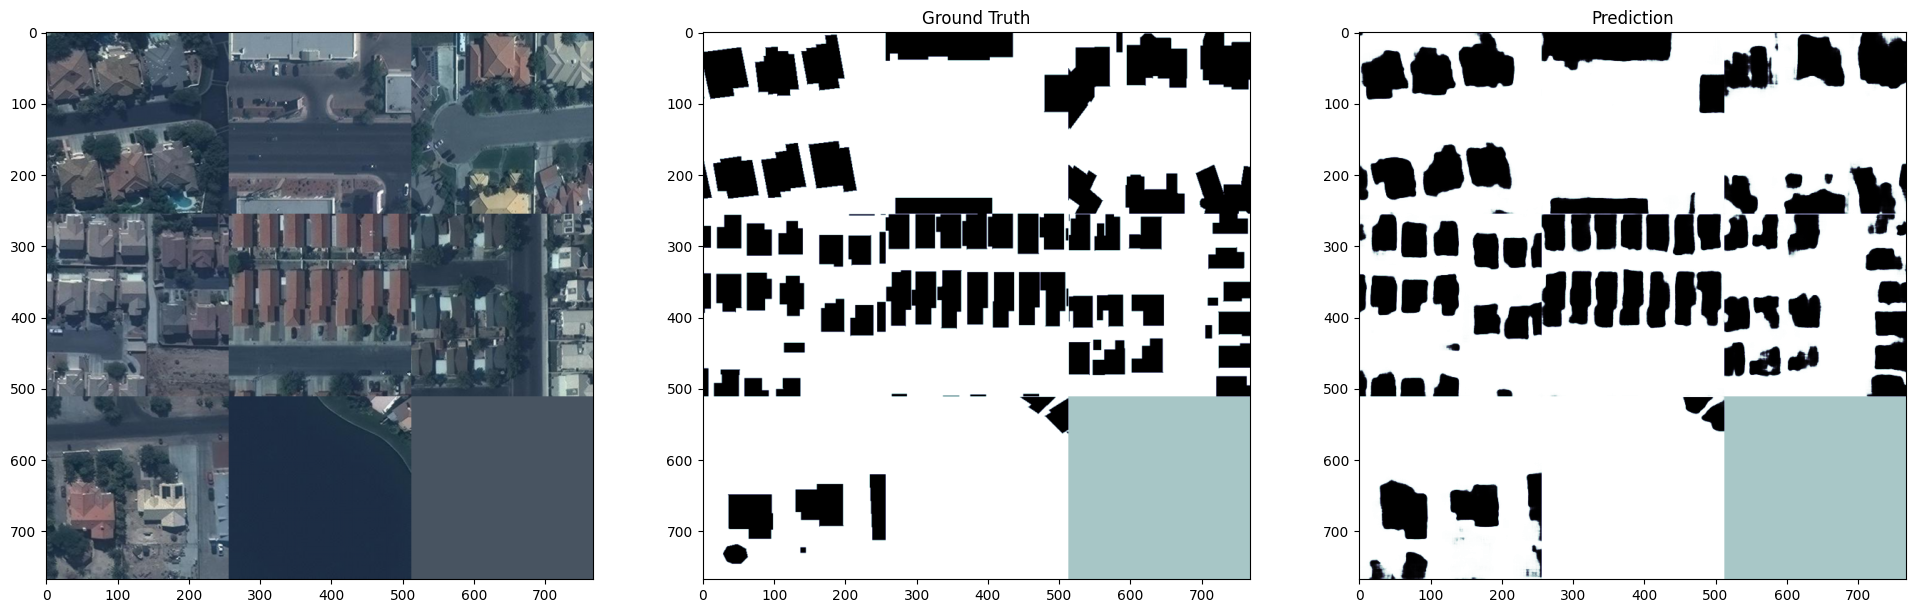

In [ ]:
from skimage.util import montage

t_x, t_y = next(valid_gen)
if t_x.shape[0]>16:
    t_x = t_x[:16]
    t_y = t_y[:16]

print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
pred_y = loaded_model.predict(t_x)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (24, 8))
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
ax1.imshow(montage_rgb(t_x))
ax2.imshow(montage(t_y[:, :, :, 0]), cmap = 'bone_r')
ax2.set_title('Ground Truth')
ax3.imshow(montage(pred_y[:, :, :, 0]), cmap = 'bone_r')
ax3.set_title('Prediction')
fig.savefig('pred_fig.png', dpi=300)

x (1, 256, 256, 3) float32 0.07333364 0.9795227
y (1, 256, 256, 1) float32 0.0 1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


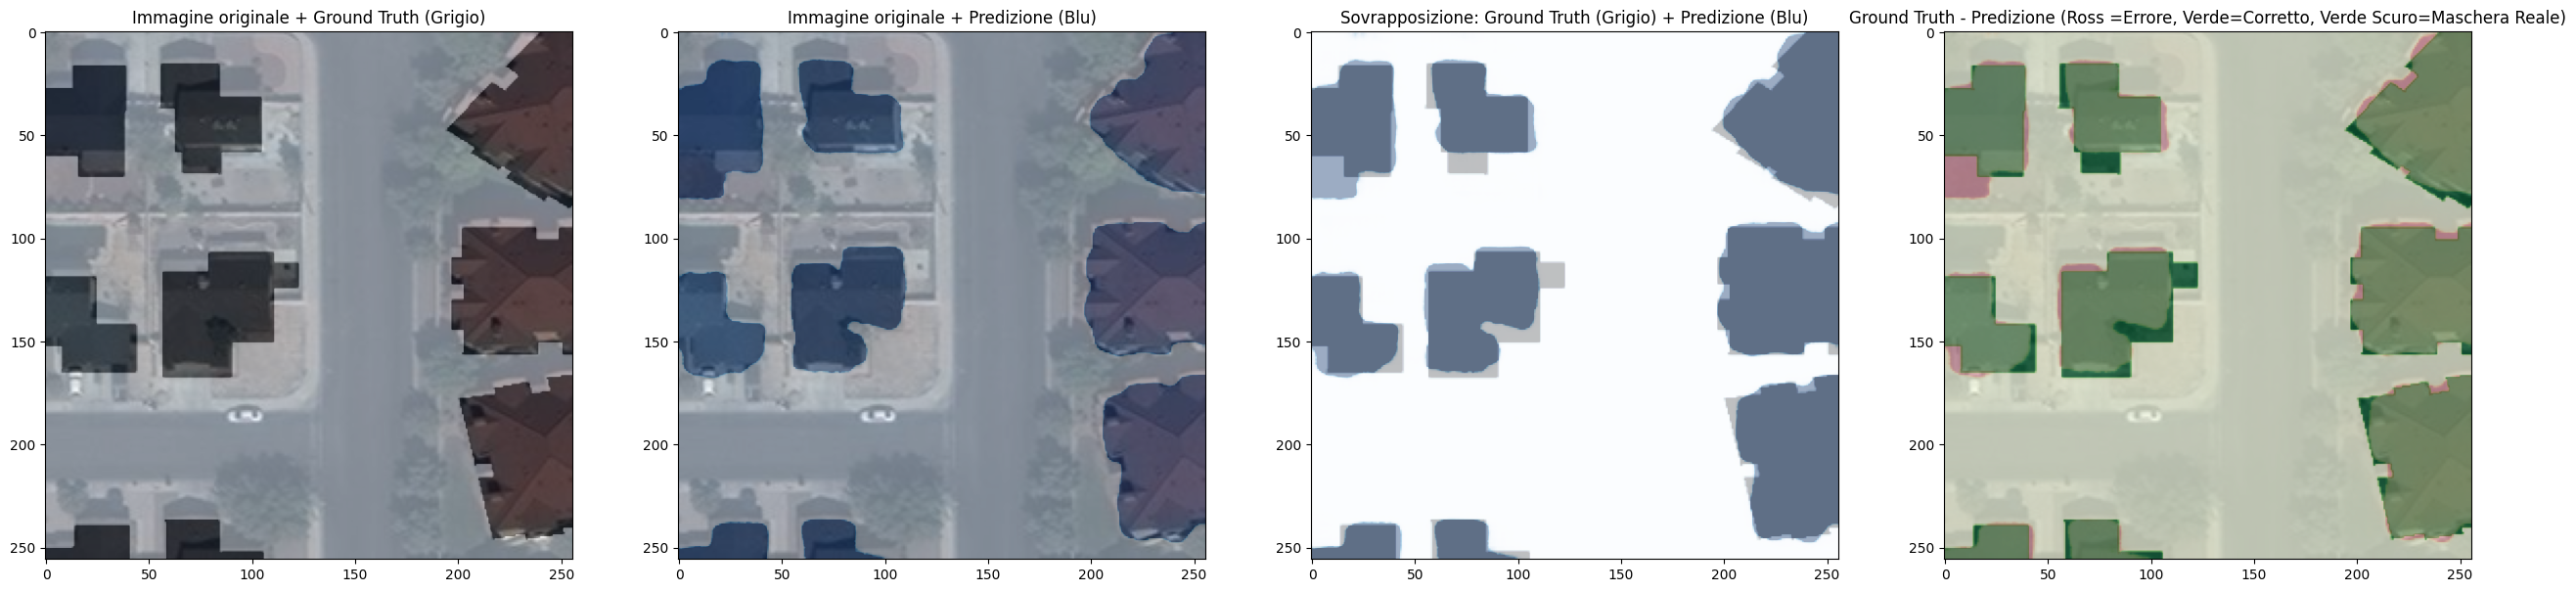

In [ ]:
import numpy as np
import tensorflow as tf
from skimage.util import montage
import matplotlib.pyplot as plt

# Fissiamo il seme per garantire ripetibilità
#np.random.seed(42)
#tf.random.set_seed(42)

# Generazione di una singola immagine e maschera
valid_gen = batch_img_gen(valid_df, 1)  # Genera 1 immagine
t_x, t_y = next(valid_gen)

print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())

# Predizione
pred_y = loaded_model.predict(t_x)

# Selezioniamo la prima immagine, ground truth e predizione
img = t_x[0]
true_mask = t_y[0, :, :, 0]
pred_mask = pred_y[0, :, :, 0]

# Calcolo della differenza tra la maschera vera e la predizione
diff_mask = true_mask - pred_mask

# Creazione della figura con 4 sotto-grafici
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(32, 8))

# 1° Grafico: immagine originale + maschera di ground truth (gialla)
ax1.imshow(img, vmin=0, vmax=1)  # Regola il contrasto dell'immagine originale
ax1.imshow(true_mask, cmap='Greys', alpha=0.4, vmax=0.6)  # Maschera con trasparenza ridotta (gialla)
ax1.set_title('Immagine originale + Ground Truth (Grigio)')

# 2° Grafico: immagine originale + predizione (blu)
ax2.imshow(img, vmin=0, vmax=1)  # Regola il contrasto dell'immagine originale
ax2.imshow(pred_mask, cmap='Blues', alpha=0.4, vmax=0.6)  # Maschera con trasparenza ridotta (blu)
ax2.set_title('Immagine originale + Predizione (Blu)')

# 3° Grafico: sovrapposizione di ground truth (giallo) e predizione (blu)
#ax3.imshow(img, vmin=0, vmax=1)  # Aggiunta dell'immagine originale sotto le maschere sovrapposte
ax3.imshow(true_mask, cmap='bone_r', alpha=0.4, vmax=0.6)  # Maschera di ground truth (gialla)
ax3.imshow(pred_mask, cmap='Blues', alpha=0.4, vmax=0.6)  # Maschera predetta (blu)
ax3.set_title('Sovrapposizione: Ground Truth (Grigio) + Predizione (Blu)')

# 4° Grafico: differenza tra ground truth e predizione (verde e rosso)
ax4.imshow(img, vmin=0, vmax=1)  # Immagine originale come sfondo
# Visualizzazione delle differenze: positivo (verde) per true_mask > pred_mask, negativo (rosso) per pred_mask > true_mask
ax4.imshow(diff_mask, cmap='RdYlGn', alpha=0.5, vmin=-1, vmax=1)  # Colormap rosso-verde per differenze
ax4.imshow(true_mask, cmap='Greens', alpha=0.4, vmax=0.6)

ax4.set_title('Ground Truth - Predizione (Ross =Errore, Verde=Corretto, Verde Scuro=Maschera Reale)')

# Salvataggio dell'immagine
fig.savefig('overlay_comparison_with_diff_colored.png', dpi=300)

plt.show()

#Secondo Approccio pre-processing dati

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import os
from PIL import Image
from matplotlib.path import Path
from skimage.color import label2rgb
import matplotlib.pyplot as plt
from skimage.io import imread


seed = 42
np.random.seed = seed


#Definiamo i percorsi
image_dir = '/content/train/images/'
json_file = '/content/annotation.json'

#Carichiamo il file JSON con le annotazioni per creare le maschere
with open(json_file, 'r') as f:
    annot_data = json.load(f)

#left join tra dataframe delle immagini e quello delle annotazioni
image_df = pd.DataFrame(annot_data['images'])
annot_df = pd.DataFrame(annot_data['annotations'])

full_df = pd.merge(annot_df, image_df, how='left', left_on = 'image_id', right_on='id').dropna()
print(full_df.head())

In [ ]:
BATCH_SIZE = 24
BUFFER_SIZE = 1000
IMG_HEIGHT = 256
IMG_WIDTH = 256

In [ ]:
def rows_to_segmentation(in_img, in_df):

    xx, yy = np.meshgrid(range(in_img.shape[0]), range(in_img.shape[1]), indexing='ij')
    out_img = np.zeros(in_img.shape[:2], dtype=np.float32)

    for _, c_row in in_df.iterrows():
        xy_vec = np.array(c_row['segmentation']).reshape((-1, 2))
        xy_path = Path(xy_vec)
        out_img += xy_path.contains_points(np.stack([yy.ravel(), xx.ravel()], -1)).reshape(out_img.shape)

    #Creiamo una maschera binaria: 0 per edifici, 1 per lo sfondo
    out_img = (out_img > 0).astype(np.float32)  # 1 per lo sfondo, 0 per edifici
    out_img = 1 - out_img  # Inverti per avere 1 come sfondo e 0 come edifici

    return out_img

In [ ]:
def create_mask(image_path):

    img_name = os.path.basename(image_path)  #Ottieniamo il nome del file
    img = imread(image_path)

    #Estraiamo l'ID dell'immagine dal nome del file
    image_id = int(os.path.splitext(img_name)[0])
    image_annotations = annot_df[annot_df['image_id'] == image_id]

    #Generiamo la mascera di segmentazione
    if not image_annotations.empty:
        mask = rows_to_segmentation(img, image_annotations)
        mask = tf.expand_dims(mask, axis=-1)  # Espandi la dimensione della maschera
    else:
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH))  # Crea una maschera vuota se non ci sono annotazioni
        mask = tf.expand_dims(mask, axis=-1)

    return mask

In [ ]:
def pre_process_image_and_mask(image, mask):

    image_resized = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH], method='bilinear')
    mask_resized = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH], method='bilinear')
    return image_resized, mask_resized

In [ ]:
def load_image_and_mask(image_path):

    #Carichiamo l'immagine
    image_path_str = image_path.numpy().decode('utf-8')  # Converti l'EagerTensor in stringa
    image = Image.open(image_path_str)
    mask = create_mask(image_path_str)

    #Convertiamo immagine e maschera in TensorFlow Tensor
    image = tf.convert_to_tensor(np.array(image), dtype=tf.float32) / 255.0  # Normalizza l'immagine
    mask = tf.convert_to_tensor(mask, dtype=tf.float32)  # La maschera è già binaria

    image_resized, mask_resized = pre_process_image_and_mask(image, mask)

    return image_resized, mask_resized

In [ ]:
import os

#Lista per salvare i percorsi delle immagini
image_paths = []

for filename in os.listdir(image_dir):
    #Creiamo il percorso completo del file
    file_path = os.path.join(image_dir, filename)
    image_paths.append(file_path)

print(len(image_paths))

In [ ]:
train_size = int(0.8 * len(image_paths))

train_image_paths = image_paths[:train_size]
test_image_paths = image_paths[train_size:]

train_dataset = tf.data.Dataset.from_tensor_slices(train_image_paths)
test_dataset = tf.data.Dataset.from_tensor_slices(test_image_paths)

train_dataset = train_dataset.map(lambda x: tf.py_function(load_image_and_mask, [x], [tf.float32, tf.float32]))
train_dataset = train_dataset.map(lambda image, mask: (tf.ensure_shape(image, [IMG_HEIGHT, IMG_WIDTH, 3]), tf.ensure_shape(mask, [IMG_HEIGHT, IMG_WIDTH, 1])))

test_dataset = test_dataset.map(lambda x: tf.py_function(load_image_and_mask, [x], [tf.float32, tf.float32]))
test_dataset = test_dataset.map(lambda image, mask: (tf.ensure_shape(image, [IMG_HEIGHT, IMG_WIDTH, 3]), tf.ensure_shape(mask, [IMG_HEIGHT, IMG_WIDTH, 1])))

In [ ]:
train_dataset.element_spec
test_dataset.element_spec

In [ ]:
train_batches = (
    train_dataset
    .cache()    #mantiene i dati nella cache
    .shuffle(BUFFER_SIZE)   #riordina i dati in maniera casuale
    .batch(BATCH_SIZE)
    .repeat()   #ripete il dataset per il training
    .prefetch(buffer_size=tf.data.AUTOTUNE))    #prepara in anticipo i prossimi batch

test_batches = test_dataset.batch(BATCH_SIZE)

In [ ]:
for images, masks in train_batches.take(1):
    print(f"Dimensioni delle immagini: {images.shape}")
    print(f"Dimensioni delle maschere: {masks.shape}")

In [ ]:
for images, masks in test_batches.take(1):
    print(f"Dimensioni delle immagini: {images.shape}")
    print(f"Dimensioni delle maschere: {masks.shape}")

In [ ]:
import matplotlib.pyplot as plt

# Funzione per visualizzare un'immagine e la sua maschera
def display_images(dataset, num_images=2):
    for images, masks in dataset.take(num_images):
        plt.figure(figsize=(10, 5))

        # Visualizza l'immagine
        plt.subplot(1, 2, 1)
        plt.imshow(images.numpy())
        plt.title('Immagine')
        plt.axis('off')

        # Visualizza la maschera
        plt.subplot(1, 2, 2)
        plt.imshow(masks.numpy(), cmap='gray')
        plt.title('Maschera')
        plt.axis('off')

        plt.show()

# Visualizza alcune immagini e maschere
display_images(train_dataset)